# Models Development(diagnosis)
by: masood janbackloo

## Steps
- Importing Data
- Train Test Split 
- Oversampling
- Transforming data
- Auxiliar functions
- Hyper parameters optimization
- Dummy Classifier
- Backtest creation
- Exporting all results/models from here


## Modules

In [ ]:
# Standard modules
from time import sleep
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

# Graphical modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preparation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Workaround for skopt with sklearn==0.23.1
from numpy.ma import MaskedArray
import sklearn.utils.fixes
sklearn.utils.fixes.MaskedArray = MaskedArray

# Development
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as XGBoost
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Evaluation
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# Export
import joblib

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 3.4 MB/s 


# Importing Data

In [ ]:
# Dataset
df = pd.read_csv('paper_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   COVID-19 Exam result           598 non-null    int64  
 1   Patient admission              598 non-null    int64  
 2   Patient age quantile           598 non-null    int64  
 3   Basophils                      598 non-null    float64
 4   Eosinophils                    598 non-null    float64
 5   Hemoglobin                     598 non-null    float64
 6   Leukocytes                     598 non-null    float64
 7   Lymphocytes                    598 non-null    float64
 8   MCHC                           598 non-null    float64
 9   MCV                            598 non-null    float64
 10  MPV                            598 non-null    float64
 11  Monocytes                      598 non-null    float64
 12  Platelets                      598 non-null    flo

# Train Test Split

In [ ]:
# Define X and Y
features = ['Patient age quantile','Basophils', 'Eosinophils','Hemoglobin', 'Leukocytes', 'Lymphocytes','MCHC','MCV','MPV',
            'Monocytes', 'Platelets', 'RDW']
# Get X and Y
x = df[features]
y = df['COVID-19 Exam result']

In [ ]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 101, stratify=y)

In [ ]:
# % of target class in train set
pd.Series(y_train).value_counts()/len(y_train)

0    0.864173
1    0.135827
Name: COVID-19 Exam result, dtype: float64

In [ ]:
# target class in train set
pd.Series(y_train).value_counts()

0    439
1     69
Name: COVID-19 Exam result, dtype: int64

In [ ]:
# % of target class in test set
y_test.value_counts()/len(y_test)

0    0.866667
1    0.133333
Name: COVID-19 Exam result, dtype: float64

In [ ]:
# target class in test set
y_test.value_counts()

0    78
1    12
Name: COVID-19 Exam result, dtype: int64

# Oversampling
Basically balance our data creating new synth samples for positive cases, using **default parameters**, i.e. `k` equals to 5.

In [ ]:
# create SMOTE object
smt = SMOTE(random_state=1206)

# Do the process
x_train_smt, y_train_smt = smt.fit_resample(x_train, y_train)

## Numerical Distribution for synthetic Cases

In [ ]:
,# Get copy of created samples
synth_samples_y = y_train_smt.copy()
# Create a new category for synth samples
synth_samples_y[len(y_train):] = 2
# Create a dataframe using oversampled data
df_synth = x_train_smt.copy()
df_synth['target'] = synth_samples_y
# Get slices for positive cases and synth positive cases
target_1 = df_synth[df_synth['target'] == 1]
target_2 = df_synth[df_synth['target'] == 2]

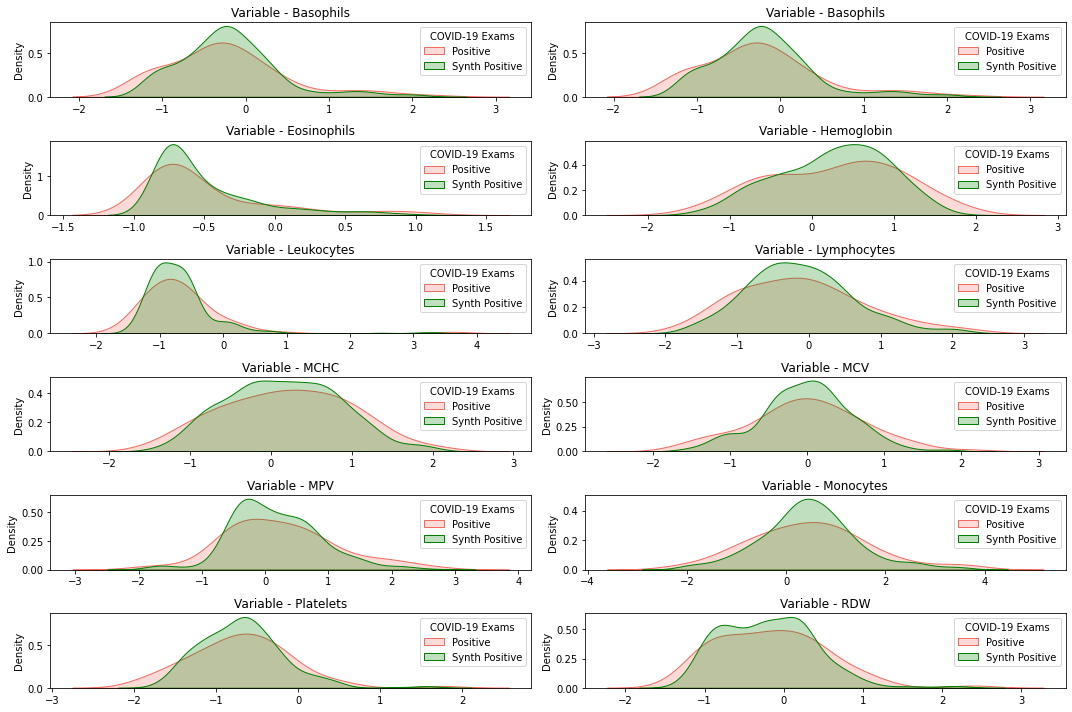

In [ ]:
# PLOT - KDE Dist plots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,10))
r = 0      # Index row
c = 0      # Index col

num_features = ['Basophils', 'Basophils', 'Eosinophils','Hemoglobin', 'Leukocytes', 'Lymphocytes','MCHC','MCV','MPV',
                'Monocytes', 'Platelets', 'RDW']

for f in num_features:
    # Plot distribuição
    sns.kdeplot(list(target_1[f]), shade=True, color='#F06C61', ax=axes[r][c], label='Positive')
    sns.kdeplot(list(target_2[f]), shade=True, color='Green', ax=axes[r][c], label='Synth Positive')
    # Plot configs
    axes[r][c].legend(title='COVID-19 Exams', loc='upper right')
    axes[r][c].set_title('Variable - ' + f)
    # Index control
    c += 1
    if c > 1:
        c = 0
        r += 1

plt.tight_layout()

## New correlation heatmap with synth features

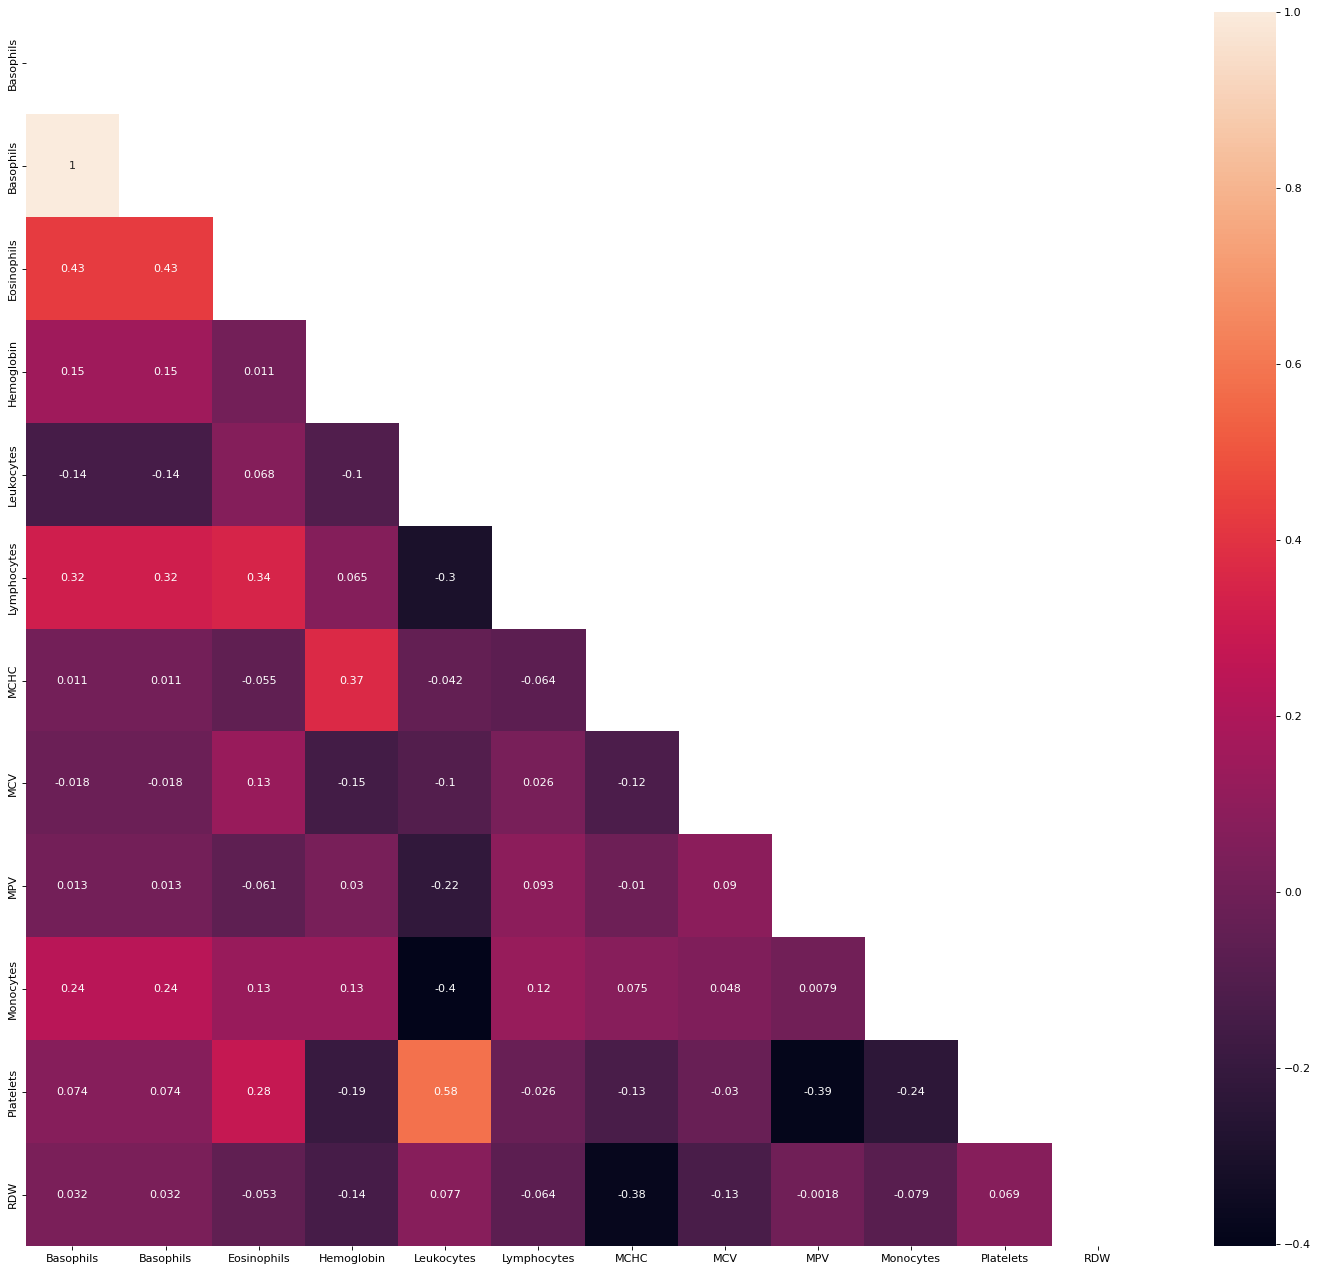

In [ ]:
# Correlation calculation
spearman_corr = df_synth[num_features].corr('spearman')
matrix = np.triu(spearman_corr)

# Plot
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(spearman_corr, annot = True, mask=matrix)
plt.tight_layout()

### Commentary
SMOTE increases some correlations, but not high enough ( > 0.8) to give any danger.

In [ ]:
sorted(list(pd.unique(x_train_smt['Patient age quantile'])))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

# Transforming data

Apply `MinMaxScaler` for **Patient age quantile** to reduce the scale difference between this variable and the numerical features

## See expected results

It's known that maximum is 19 and minimum is 0

In [ ]:
age_origin = sorted(list(pd.unique(x_train['Patient age quantile'])))
age_transf = sorted(list(pd.unique(x_train['Patient age quantile'])/19))
for origin, transf in zip(age_origin, age_transf):
    print(origin, '->', round(transf,6))

0 -> 0.0
1 -> 0.052632
2 -> 0.105263
3 -> 0.157895
4 -> 0.210526
5 -> 0.263158
6 -> 0.315789
7 -> 0.368421
8 -> 0.421053
9 -> 0.473684
10 -> 0.526316
11 -> 0.578947
12 -> 0.631579
13 -> 0.684211
14 -> 0.736842
15 -> 0.789474
16 -> 0.842105
17 -> 0.894737
18 -> 0.947368
19 -> 1.0


## Apply Transformation

In [ ]:
# Define instance and fit in train set
mms = MinMaxScaler().fit(np.array(x_train['Patient age quantile']).reshape(-1, 1))

In [ ]:
# Apply transformation x train
x_train['Patient age quantile'] = mms.transform(np.array(x_train['Patient age quantile']).reshape(-1, 1)).round(6)
# Apply transformation x test
x_test['Patient age quantile'] = mms.transform(np.array(x_test['Patient age quantile']).reshape(-1, 1)).round(6)
# Apply transformation x train with SMOTE
x_train_smt['Patient age quantile'] = mms.transform(np.array(x_train_smt['Patient age quantile']).reshape(-1, 1)).round(6)
# Apply transformation df
df['Patient age quantile'] = mms.transform(np.array(df['Patient age quantile']).reshape(-1, 1)).round(6)

In [ ]:
x_train.head()

,Patient age quantile,Basophils,Eosinophils,Hemoglobin,Leukocytes,Lymphocytes,MCHC,MCV,MPV,Monocytes,Platelets,RDW
371,0.473684,-0.529226,-0.203417,-0.460932,0.178103,0.625411,-0.054585,0.386517,-0.550290,-0.456613,1.844207,-0.536617
586,0.368421,-1.140144,0.428674,-1.588740,-0.509246,0.437772,-1.349101,-0.594931,-2.120995,0.830284,1.668342,0.171035
28,0.789474,-1.140144,-0.835508,-0.460932,-1.138157,-0.671003,-0.154166,0.807138,1.132609,-0.220244,-0.542537,-0.005877
162,0.684211,0.692611,0.133698,-0.836868,-0.909968,1.307735,0.044991,0.046015,-1.447836,-0.430350,0.286543,-0.182790
293,0.210526,-0.529226,-0.793368,-1.651396,0.155841,-0.116616,1.339507,0.967375,-1.223449,1.355549,1.366858,-0.005877


# Auxiliar Functions

In [ ]:
def printModelGeneralInfo(model, hp, score, metric_evaluated):
    print('#####################################################')
    print('Model:', type(model).__name__)
    print('Metric: ', metric_evaluated, ' | Score (%): ', 100*round(score,5))
    print('Best Parameters: ', hp)
    print('#####################################################\n')

In [ ]:
def optimizationGridCV(model_estimator, params, metric_to_eval, cv_generator, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Grid Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        cv_generator: Stratified K-Fold Generator to guarantee reproductibility
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Random Search CV object
    hp_search = GridSearchCV(estimator=model_estimator,param_grid=params,cv=cv_generator,
                             scoring=metric_to_eval,verbose=2,n_jobs=-1)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [ ]:
def optimizationRandomCV(model_estimator, params, metric_to_eval, cv_generator, n_iter, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Random Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        cv_generator: Stratified K-Fold Generator to guarantee reproductibility
        n_iter: iterations in RandomizedSearchCV
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Random Search CV object
    hp_search = RandomizedSearchCV(estimator=model_estimator,
                                   param_distributions=params, 
                                   n_iter=n_iter,
                                   cv=cv_generator,
                                   scoring=metric_to_eval,
                                   verbose=2,
                                   random_state=101,
                                   n_jobs=-1)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [ ]:
def optimizationBayesCV(model_estimator, params, metric_to_eval, cv_generator, n_iter, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Bayes Optimization Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        cv_generator: Stratified K-Fold Generator to guarantee reproductibility
        n_iter: iterations in BayesSearchCV
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Search CV object
    hp_search = BayesSearchCV(estimator=model_estimator,
                              search_spaces=params,
                              n_iter=n_iter,
                              cv=cv_generator,
                              scoring=metric_to_eval,
                              verbose=0,
                              random_state=101,
                              n_jobs=5,
                              n_points=5)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [ ]:
def optimizationPipeline(estimator,params,x_train,y_train,metric_eval,cv_generator,opt_option='grid',n_iter=None):
    """
    Function to apply a specific HP optimization and present results.
    Arguments:
        estimator: Model to be evaluated
        params: hyper parameters grid
        x_train: self explanatory
        y_train: self explanatory
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        opt_option: define the methodology to HP Optimization. Can be 'grid','random' or 'bayes'
        cv_generator: Stratified K-Fold Generator to guarantee reproductibility
        n_iter: iterations in RandomSearchCV or BayesOptimization. It's ignored if opt_option is 'grid'.
    Returns:
        dictionary with overall results
    """  
    # 1 - SEARCH
    if opt_option == 'grid':
        best_model,best_params,best_score,cv_results = optimizationGridCV(estimator,params,metric_eval,cv_generator,
                                                                          x_train,y_train)
    elif opt_option == 'random':
        best_model,best_params,best_score,cv_results = optimizationRandomCV(estimator,params,metric_eval,cv_generator,
                                                                            n_iter,x_train,y_train)
    elif opt_option == 'bayes':
        best_model,best_params,best_score,cv_results = optimizationBayesCV(estimator,params,metric_eval,cv_generator,
                                                                           n_iter,x_train,y_train)
    else:
        print('ERROR - Wrong opt_option selected')
        return
    
    # Wait for results
    sleep(1.5)    
    # 2 - Show Model Results
    printModelGeneralInfo(best_model, best_params, best_score, metric_eval)
    # 3 - Returns
    returned_dict = {'best_model':best_model,'best_params':best_params,'best_score':best_score,
                     'cv_res':pd.DataFrame(cv_results),'metric_used':metric_eval}
    return returned_dict

# Hyper parameters optimization

Details:
- **Metrics**: `f1` which represents F1-Score
- **Models**: Logistic Regression, SVM, Random Forest, Gradient Boosting and XGBoost
- **Process to optimize**: CV 5-Fold Strafied. Optimization algorithm is Bayes Optimization.

In [ ]:
# Metric used
metric_optimize = 'f1'

In [ ]:
# Stratified K-Fold generator - Generate a general split to be able to compare all models with CV results
strat_cv_5folds = StratifiedKFold(n_splits=5,random_state=101, shuffle=True)

## HPO Procedure

### Logistic Regression oversampled

In [ ]:
## Define Estimator
estimator = LogisticRegression(random_state=1206,penalty='elasticnet', solver='saga', max_iter=5000)
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'l1_ratio': Real(0, 1, prior='uniform'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
lre_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize, 
                                   strat_cv_5folds,opt_option='bayes',n_iter=100)

#####################################################
Model: LogisticRegression
Metric:  f1  | Score (%):  83.136
Best Parameters:  OrderedDict([('C', 0.05520658088086791), ('class_weight', None), ('l1_ratio', 1.0)])
#####################################################



### Logistic Regression imbalanced

In [ ]:
## Define Estimator
estimator = LogisticRegression(random_state=1206,penalty='elasticnet', solver='saga', max_iter=5000)
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'l1_ratio': Real(0, 1, prior='uniform'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
lre_res_bal = optimizationPipeline(estimator,params,x_train,y_train,metric_optimize, 
                                   strat_cv_5folds,opt_option='bayes',n_iter=100)

#####################################################
Model: LogisticRegression
Metric:  f1  | Score (%):  50.196
Best Parameters:  OrderedDict([('C', 0.04181776160662577), ('class_weight', 'balanced'), ('l1_ratio', 0.292546405054023)])
#####################################################



### SVM oversampled

In [ ]:
## Define Estimator
estimator = SVC(random_state=1206, probability=True)
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'shrinking': Categorical([True, False], transform='onehot'),
          'kernel': Categorical(['linear','rbf','poly','sigmoid'], transform='onehot'),
          'gamma': Categorical(['scale', 'auto'], transform='onehot'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
svm_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: SVC
Metric:  f1  | Score (%):  95.56099999999999
Best Parameters:  OrderedDict([('C', 10.0), ('class_weight', 'balanced'), ('gamma', 'scale'), ('kernel', 'rbf'), ('shrinking', False)])
#####################################################



### SVM imbalnced

In [ ]:
## Define Estimator
estimator = SVC(random_state=1206, probability=True)
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'shrinking': Categorical([True, False], transform='onehot'),
          'kernel': Categorical(['linear','rbf','poly','sigmoid'], transform='onehot'),
          'gamma': Categorical(['scale', 'auto'], transform='onehot'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
svm_res_bal = optimizationPipeline(estimator,params,x_train,y_train,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: SVC
Metric:  f1  | Score (%):  60.757000000000005
Best Parameters:  OrderedDict([('C', 10.0), ('class_weight', 'balanced'), ('gamma', 'auto'), ('kernel', 'rbf'), ('shrinking', False)])
#####################################################



### Random Forest oversampled

In [ ]:
## Define Estimator
estimator = RandomForestClassifier(random_state=1206, criterion='gini', warm_start=True)
## Define Parameters Grid
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'class_weight': Categorical(['balanced','balanced_subsample',None], transform='onehot'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
rfc_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: RandomForestClassifier
Metric:  f1  | Score (%):  95.253
Best Parameters:  OrderedDict([('class_weight', 'balanced'), ('max_depth', 19), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000)])
#####################################################



### Random Forest imbalnced 

In [ ]:
## Define Estimator
estimator = RandomForestClassifier(random_state=1206, criterion='gini', warm_start=True)
## Define Parameters Grid
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'class_weight': Categorical(['balanced','balanced_subsample',None], transform='onehot'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
rfc_res_ove = optimizationPipeline(estimator,params,x_train,y_train,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: RandomForestClassifier
Metric:  f1  | Score (%):  57.156
Best Parameters:  OrderedDict([('class_weight', 'balanced'), ('max_depth', 18), ('max_features', 'log2'), ('min_samples_leaf', 4), ('min_samples_split', 3), ('n_estimators', 334)])
#####################################################



### Gradient Boosting oversampled 

In [ ]:
## Define Estimator
estimator = GradientBoostingClassifier(random_state=1206, loss='deviance', criterion='friedman_mse', warm_start=True)
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-5, 10, prior='log-uniform'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
bst_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

KeyboardInterrupt: ignored

### Gradient Boosting imbalnced 

In [ ]:
## Define Estimator
estimator = GradientBoostingClassifier(random_state=1206, loss='deviance', criterion='friedman_mse', warm_start=True)
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-5, 10, prior='log-uniform'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
bst_res_ove = optimizationPipeline(estimator,params,x_train,y_train ,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: GradientBoostingClassifier
Metric:  f1  | Score (%):  50.3
Best Parameters:  OrderedDict([('learning_rate', 0.6410921070892291), ('max_depth', 32), ('max_features', 'sqrt'), ('min_samples_leaf', 8), ('min_samples_split', 8), ('n_estimators', 100), ('subsample', 1.0)])
#####################################################





```
# This is formatted as code
```

### XGBoost oversampled


In [ ]:
## Define Estimator
estimator = XGBClassifier(objective='binary:logistic',random_state=1206,booster='gbtree', eval_metric='logloss')
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_child_weight': Integer(1, 10, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'colsample_bytree': Real(0.75, 1, prior='uniform'),
          'scale_pos_weight': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-6, 10, prior='log-uniform'),
          'gamma': Real(1e-4, 10, prior='log-uniform'),
          'reg_alpha': Real(1e-3, 10, prior='log-uniform'),
          'reg_lambda': Real(1e-3, 10, prior='log-uniform')}
## HP Optimization
xgb_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: XGBClassifier
Metric:  f1  | Score (%):  94.65599999999999
Best Parameters:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0001), ('learning_rate', 0.6498023209664956), ('max_depth', 7), ('min_child_weight', 1), ('n_estimators', 693), ('reg_alpha', 0.001), ('reg_lambda', 10.0), ('scale_pos_weight', 0.9228096215629069), ('subsample', 0.75)])
#####################################################



### XGBoost imbalanced 

In [ ]:
## Define Estimator
estimator = XGBClassifier(objective='binary:logistic',random_state=1206,booster='gbtree', eval_metric='logloss')
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_child_weight': Integer(1, 10, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'colsample_bytree': Real(0.75, 1, prior='uniform'),
          'scale_pos_weight': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-6, 10, prior='log-uniform'),
          'gamma': Real(1e-4, 10, prior='log-uniform'),
          'reg_alpha': Real(1e-3, 10, prior='log-uniform'),
          'reg_lambda': Real(1e-3, 10, prior='log-uniform')}
## HP Optimization
xgb_res_ove = optimizationPipeline(estimator,params,x_train,y_train,metric_optimize,strat_cv_5folds,
                                   opt_option='bayes',n_iter=100)

#####################################################
Model: XGBClassifier
Metric:  f1  | Score (%):  45.111000000000004
Best Parameters:  OrderedDict([('colsample_bytree', 0.802078857522152), ('gamma', 0.014391393532718445), ('learning_rate', 0.2752619704188678), ('max_depth', 27), ('min_child_weight', 7), ('n_estimators', 162), ('reg_alpha', 0.08201966342731955), ('reg_lambda', 0.002644907648702297), ('scale_pos_weight', 0.9354692268991764), ('subsample', 0.9009380661900361)])
#####################################################



## Saving BO5-CV results in a dataframe

In [ ]:
# Columns to save for overall results
cols_cv = ['split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score', 'split4_test_score', 
           'mean_test_score','std_test_score','rank_test_score']

In [ ]:
# Creating df with B05CV results for all models
df_bo5cv_bests = lre_res_ove['cv_res'].loc[lre_res_ove['cv_res']['rank_test_score'] == 1][cols_cv]
df_bo5cv_bests = df_bo5cv_bests.append(svm_res_ove['cv_res'].loc[svm_res_ove['cv_res']['rank_test_score'] == 1][cols_cv])
df_bo5cv_bests = df_bo5cv_bests.append(rfc_res_ove['cv_res'].loc[rfc_res_ove['cv_res']['rank_test_score'] == 1][cols_cv])
df_bo5cv_bests = df_bo5cv_bests.append(bst_res_ove['cv_res'].loc[bst_res_ove['cv_res']['rank_test_score'] == 1][cols_cv])
df_bo5cv_bests = df_bo5cv_bests.append(xgb_res_ove['cv_res'].loc[xgb_res_ove['cv_res']['rank_test_score'] == 1][cols_cv])
df_bo5cv_bests.reset_index(drop=True, inplace=True)
df_bo5cv_bests

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.835165,0.847458,0.858696,0.834225,0.781250,0.831359,0.026609,1
1,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
2,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
3,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
4,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
5,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
6,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
7,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
8,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
9,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1


In [ ]:
# Erase sample 3 because is another RF, but more complex and with the same metrics from sample 2 (another rf)
df_bo5cv_bests = df_bo5cv_bests.loc[[0,1,2,4,5],:]
df_bo5cv_bests.reset_index(drop=True, inplace=True)
df_bo5cv_bests

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.835165,0.847458,0.858696,0.834225,0.781250,0.831359,0.026609,1
1,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
2,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
3,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1
4,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1


In [ ]:
# Set name columns
df_bo5cv_bests['ai_algorithm'] = ['lre','svm','rfc','bst','xgb']

In [ ]:
# Overall dataset
df_bo5cv_bests

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,ai_algorithm
0,0.835165,0.847458,0.858696,0.834225,0.781250,0.831359,0.026609,1,lre
1,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1,svm
2,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1,rfc
3,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1,bst
4,0.977778,0.967033,0.977528,0.910053,0.945652,0.955609,0.025600,1,xgb


# Baseline Classifiers

### Most Frequent

In [ ]:
# Create
model_dummy_mf_ove = DummyClassifier(strategy="most_frequent")
# Fit
model_dummy_mf_ove.fit(x_train_smt,y_train_smt)

DummyClassifier(strategy='most_frequent')

### Stratified

In [ ]:
# Create
model_dummy_st_ove = DummyClassifier(strategy="stratified")
# Fit
model_dummy_st_ove.fit(x_train_smt,y_train_smt)

DummyClassifier(strategy='stratified')

# Backtest - Generate dataset
Samples from test set where **COVID is negative** and **Any respiratory disease is positive**

## Functions

In [ ]:
def getMatchIdx(idx1, idx2):
    return list(set(idx1) & set(idx2))

def backtestReport(backtestIdx, label, trainIdx, testIdx):
    print('###################',label)
    print('All Match Condition  -',len(backtestIdx),'samples.')
    print('Train Match Conditon -',len(getMatchIdx(trainIdx, backtestIdx)),'samples.')
    print('Test Match Conditon  -',len(getMatchIdx(testIdx, backtestIdx)),'samples.')

## Get all samples

In [ ]:
x_resp=df[(df['COVID-19 Exam result'] == 0)&(df['Respiratory Disease detection'] == 1)][features]

## Get a report about how those samples are distributed

In [ ]:
backtestReport(x_resp.index, 'Any Respiratory disease', x_train.index, x_test.index)

################### Any Respiratory disease
All Match Condition  - 172 samples.
Train Match Conditon - 146 samples.
Test Match Conditon  - 26 samples.


## Get backtest samples only present in test set

In [ ]:
x_resp = x_resp.loc[getMatchIdx(x_test.index, x_resp.index), :]

In [ ]:
# Validate
len(x_resp)

26

# Export results

In [ ]:
# Function to export best models
def exportModels(best_models_names, best_models_objects,type_of_dataset):
    for model_name, model_object in zip(best_models_names, best_models_objects):
        joblib.dump(model_object, 'model_'+model_name+'_'+type_of_dataset+'.sav')

In [ ]:
# Name of the models
models_name_list = ['lre','svm','rfc','bst','xgb','dummy_mf','dummy_st']


## Saving Datasets...

In [ ]:
# XY trainset before SMOTE
x_train.to_csv('results_modelsDevelopment/x_train.csv',index=False)
y_train.to_csv('results_modelsDevelopment/y_train.csv',index=False)
# XY trainset with SMOTE
x_train_smt.to_csv('results_modelsDevelopment/x_train_SMOTE.csv',index=False)
y_train_smt.to_csv('results_modelsDevelopment/y_train_SMOTE.csv',index=False)
# XY testset
x_test.to_csv('results_modelsDevelopment/x_test.csv',index=False)
y_test.to_csv('results_modelsDevelopment/y_test.csv',index=False)
# Backtest datasets - Only X because Y is a zero array
x_resp.to_csv('results_modelsDevelopment/x_resp.csv',index=False)
# Dataset with age transformation
df.to_csv('results_modelsDevelopment/paper_dataset_age_transformed.csv',index=False)
# BO5CV best results for all models
df_bo5cv_bests.to_csv('results_modelsDevelopment/BO5CV_best_results.csv',index=False)
# BO5CV all results for all models
lre_res_ove['cv_res'].to_csv('results_modelsDevelopment/BO5CV_lre_results.csv',index=False)
svm_res_ove['cv_res'].to_csv('results_modelsDevelopment/BO5CV_svm_results.csv',index=False)
rfc_res_ove['cv_res'].to_csv('results_modelsDevelopment/BO5CV_rfc_results.csv',index=False)
bst_res_ove['cv_res'].to_csv('results_modelsDevelopment/BO5CV_bst_results.csv',index=False)
xgb_res_ove['cv_res'].to_csv('results_modelsDevelopment/BO5CV_xgb_results.csv',index=False)

## Saving models ...

In [ ]:
# Define objects
models_objects_list = [lre_res_bal['best_model'],svm_res_bal['best_model'],rfc_res_ove['best_model'],bst_res_ove['best_model'],
                       xgb_res_ove['best_model'],]
# Use the function
exportModels(models_name_list, models_objects_list,'balanced')